# Transform M8 and annotate sequences
## This notebook transforms the MMseqs M8 result of mapping all the swissprot species on Human.

**Description:**
1. Download swssprot sequences.
2. Extract the mammalian sequences.
3. Extract the mammalian sequences WithOut human.
4. Select the best human hit for every species.
5. Annotate and write a new Fasta file with the AG field *(Annotation Group)*.
6. Draw a histogram of the best hits percentage identities.

```bash
wget ftp://ftp.uniprot.org/pub/databases/uniprot/current_release/knowledgebase/complete/uniprot_sprot.fasta.gz
```

In [8]:
%%bash

# Swissprot mammalian only
cat uniprot_sprot.fasta | grep -w -f mammalian_taxas.txt | cut -c 2- > mammalian_headers.txt
cat uniprot_sprot.fasta | seqkit grep -n -f mammalian_headers.txt > swissprot_mammalian.fa

# Mammalian without human
cat swissprot_mammalian.fa | seqkit grep -n -r -p "OX=9606\s" -v > swissprot_mammalian_wo_human.fa

In [1]:
"""
Annotating swissProt sequences by the m8 MMseqs2 output file                                      #

[0]query [1]target [2]pident [3]alnlen [4]mismatch [5]gapopen [6]qstart [7]qend [8]tstart [9]tend [10]evalue [11]bits 
P62807	Q6ZWY9	1.000	126	0	0	1	126	1	126	3.978E-71	236
P62807	Q5R893	1.000	126	0	0	1	126	1	126	3.978E-71	236
"""

from itertools import groupby
import textwrap
import sys

In [2]:
m8_file = "result.m8"
fasta_file = "swissprot_mammalian_wo_human.fa"

species_to_human = dict()
species_to_AG = dict()
pair_to_pident = dict()

In [3]:
def fasta_iter(fasta_name):
    """
    Thanks to https://www.biostars.org/p/710
    given a fasta file. yield tuples of header, sequence
    """
    fh = open(fasta_name, 'r')
    # ditch the boolean (x[0]) and just keep the header or sequence since
    # we know they alternate.
    faiter = (x[1] for x in groupby(fh, lambda line: line[0] == ">"))
    for header in faiter:
        header = next(header)[1:].strip()
        seq = "".join(s.strip() for s in next(faiter))
        yield header, seq

In [4]:
# Parsing
with open(m8_file, 'r') as m8:
    for line in m8:
        line = line.strip().split()
        human = line[0]
        species = line[1]
        evalue = float(line[10])
        pident = float(line[2])
        pair_to_pident[(human,species)] = pident
        if species not in species_to_human:
            species_to_human[species] = dict()
                    
        species_to_human[species][human] = evalue

In [5]:
for species, human_scores in species_to_human.items():
    species_to_AG[species] = min(human_scores, key=human_scores.get)

In [6]:
# Rewriting
with open(f"annotated_{fasta_file}", 'w') as new_fasta:
    for header, seq in fasta_iter(fasta_file):
        species_seqID = header.split('|')[1]
        best_humanGene = species_to_AG.get(species_seqID, "NaN")
        header += f"AG={best_humanGene}"
        new_fasta.write('>' + header + '\n')
        new_fasta.write(textwrap.fill(seq, 60) + '\n')

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

In [8]:
species_to_pident_histo = list()
for species, AG in species_to_AG.items():
    pident = pair_to_pident[(AG,species)]
    species_to_pident_histo.append(pident)

In [11]:
sns.set(color_codes=True)

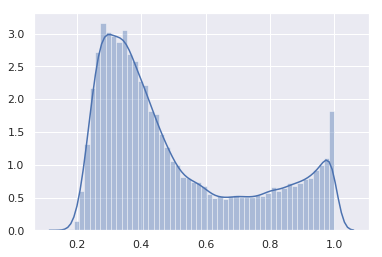

In [12]:
sns.distplot(species_to_pident_histo)